In [1]:
import pandas as pd
import numpy as np
from scipy import spatial
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import fiona
import statistics
import contextily as cx

In [2]:
mypath = '/home/selihadji/Documenti/papers/Platoon_II/trips/'

In [3]:
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [4]:
def filterSubstr(lists, substr):
    return [x for x in lists if substr in x]

searchString = '2022_09_14'
onlyfiles_14_09 = filterSubstr(onlyfiles, searchString)
onlyfiles_14_09

searchString = '11_45'
onlyfiles = filterSubstr(onlyfiles_14_09, searchString)
onlyfiles

#searchString2 = '_12_28'
#onlyfiles2 = filterSubstr(onlyfiles_14_09, searchString2)
#onlyfiles = onlyfiles1 + onlyfiles2
#onlyfiles

['2022_09_14_RG Logi Jeep_11_45_12_02_7e79a995-77a4-4310-8c60-ba215a2a58df.csv',
 '2022_09_14_PS Skylark Test_11_45_12_02_ec2500ce-8506-401a-be11-103515843b1e.csv',
 '2022_09_14_LA2 Logi Jeep_11_45_12_02_6aea80b8-9f0c-4319-96cc-c64f9bd8f225.csv']

In [5]:
allfiles = []
for i in range(len(onlyfiles)):
    df = pd.read_csv(mypath + str(onlyfiles[i]), sep=';', decimal=',')
    df['Time[ms]'] = pd.to_datetime(df['Time[ms]'], unit='ms')
    df['driver'] = str(onlyfiles[i])[11:13]
    coord_ = [Point(x, y) for x, y in zip(df.Longitude, df.Latitude)]
    alldata_ = gpd.GeoDataFrame(df, geometry=coord_, crs ="EPSG:4326")
    allfiles.append(df)
alldata = pd.concat(allfiles, axis=0).reset_index(drop=True)

In [6]:
alldata['data'] = alldata['Time[ms]'].dt.date

In [7]:
alldata["data"] = pd.to_datetime(alldata["data"])

In [8]:
alldata_RG = alldata[alldata.driver == 'RG']
alldata_PS = alldata[alldata.driver == 'PS']
alldata_LA = alldata[alldata.driver == 'LA']

In [9]:
allfiles = []
for i in range(len(onlyfiles)):
    df = pd.read_csv(mypath + str(onlyfiles[i]), sep=';', decimal=',')
    df['Time[ms]'] = pd.to_datetime(df['Time[ms]'], unit='ms')
    df['driver'] = str(onlyfiles[i])[11:13]
    coord_ = [Point(x, y) for x, y in zip(df.Longitude, df.Latitude)]
    alldata_ = gpd.GeoDataFrame(df, geometry=coord_, crs ="EPSG:4326")
    allfiles.append(df)

In [10]:
alldata = pd.concat(allfiles, axis=0).reset_index(drop=True)

In [11]:
alldata.driver.unique()

array(['RG', 'PS', 'LA'], dtype=object)

In [12]:
alldata_SORTED = alldata.sort_values(by = 'Time[ms]').reset_index(drop=True)

In [13]:
alldata_SORTED_cut = alldata_SORTED.iloc[110:].dropna().reset_index(drop=True)

In [14]:
alldata_SORTED_cut['Time'] = pd.to_datetime(alldata_SORTED_cut['Time[ms]'].dt.strftime('%H:%M:%S'))

In [15]:
rg = alldata_SORTED_cut[alldata_SORTED_cut.driver == 'RG'].reset_index(drop=True).drop_duplicates()
la = alldata_SORTED_cut[alldata_SORTED_cut.driver == 'LA'].reset_index(drop=True).drop_duplicates()
ps = alldata_SORTED_cut[alldata_SORTED_cut.driver == 'PS'].reset_index(drop=True).drop_duplicates()

In [16]:
from haversine import haversine, Unit
import haversine as hs

In [17]:
platoon_alldist = []
platoon_all_CO2 = []

platoon_all_lat_dist = []
platoon_all_lon_dist = []

platoon_all_lat_CO2 = []
platoon_all_lon_CO2 = []

#ps --> rg
#jc --> la
#dw --> ps


for i in range(len(rg)):
    platoon_lat_dist = []
    platoon_lon_dist = []
    platoon_lat_CO2 = []
    platoon_lon_CO2 = []
    platoon_dist = []
    CO2_max = []
    dist_mat = []
    
    rg_ = rg.iloc[i]
    
    df_array1 = (rg_.Latitude, rg_.Longitude)

    la_ = la[la['Time'] > rg_['Time']].reset_index(drop=True)
    df_array2 = list(zip(la_.Latitude, la_.Longitude))[0:60]
        
    for j in range(len(df_array2)):
        dist_mat.append(hs.haversine(df_array1,df_array2[j],unit=Unit.METERS))

    la_mindist = min(dist_mat)
    la_mindist_index = dist_mat.index(la_mindist)

    platoon_dist.append(la_mindist)

    platoon_lat_dist.append(la_.iloc[la_mindist_index]["Latitude"])
    platoon_lon_dist.append(la_.iloc[la_mindist_index]["Longitude"])

    CO2 = []
    CO2.append(la_.iloc[0]['CO2[kg]'])
    try:
        CO2.extend(list(la_.iloc[1:21]['CO2[kg]']))
    except:
        pass
    
    la_maxCO2 = max(CO2)
    la_maxCO2_index = CO2.index(la_maxCO2)
    CO2_max.append(la_.reset_index(drop=True).iloc[la_maxCO2_index]['CO2[kg]'])
    platoon_lat_CO2.append(la_.reset_index(drop=True).iloc[la_maxCO2_index]["Latitude"])
    platoon_lon_CO2.append(la_.reset_index(drop=True).iloc[la_maxCO2_index]["Longitude"])    


    ps_ = ps[ps['Time'] > la_['Time'][la_mindist_index]].reset_index(drop=True)
    df_array3 = list(zip(ps_.Latitude, ps_.Longitude))[0:60]        
    
    dist_mat = []

    for j in range(len(df_array3)):
        dist_mat.append(hs.haversine(df_array2[la_mindist_index],df_array3[j],unit=Unit.METERS))

    ps_mindist = min(dist_mat)
    ps_mindist_index = dist_mat.index(ps_mindist)

    platoon_dist.append(ps_mindist)
    platoon_lat_dist.append(ps_.reset_index(drop=True).iloc[ps_mindist_index]["Latitude"])
    platoon_lon_dist.append(ps_.reset_index(drop=True).iloc[ps_mindist_index]["Longitude"])    

    CO2 = []

    CO2.append(ps_.iloc[0]['CO2[kg]'])
    try:
        CO2.extend(list(ps_.iloc[1:21]['CO2[kg]']))
    except:
        pass
    ps_maxCO2 = max(CO2)
    ps_maxCO2_index = CO2.index(ps_maxCO2)
    CO2_max.append(ps_.reset_index(drop=True).iloc[ps_maxCO2_index]['CO2[kg]'])
    platoon_lat_CO2.append(ps_.reset_index(drop=True).iloc[ps_maxCO2_index]["Latitude"])
    platoon_lon_CO2.append(ps_.reset_index(drop=True).iloc[ps_maxCO2_index]["Longitude"])  

      
    platoon_all_lat_dist.append(platoon_lat_dist)
    platoon_all_lon_dist.append(platoon_lon_dist)
    platoon_all_lat_CO2.append(platoon_lat_CO2)
    platoon_all_lon_CO2.append(platoon_lon_CO2)
    platoon_alldist.append(platoon_dist)
    platoon_all_CO2.append(CO2_max)

ValueError: min() arg is an empty sequence

<Axes: >

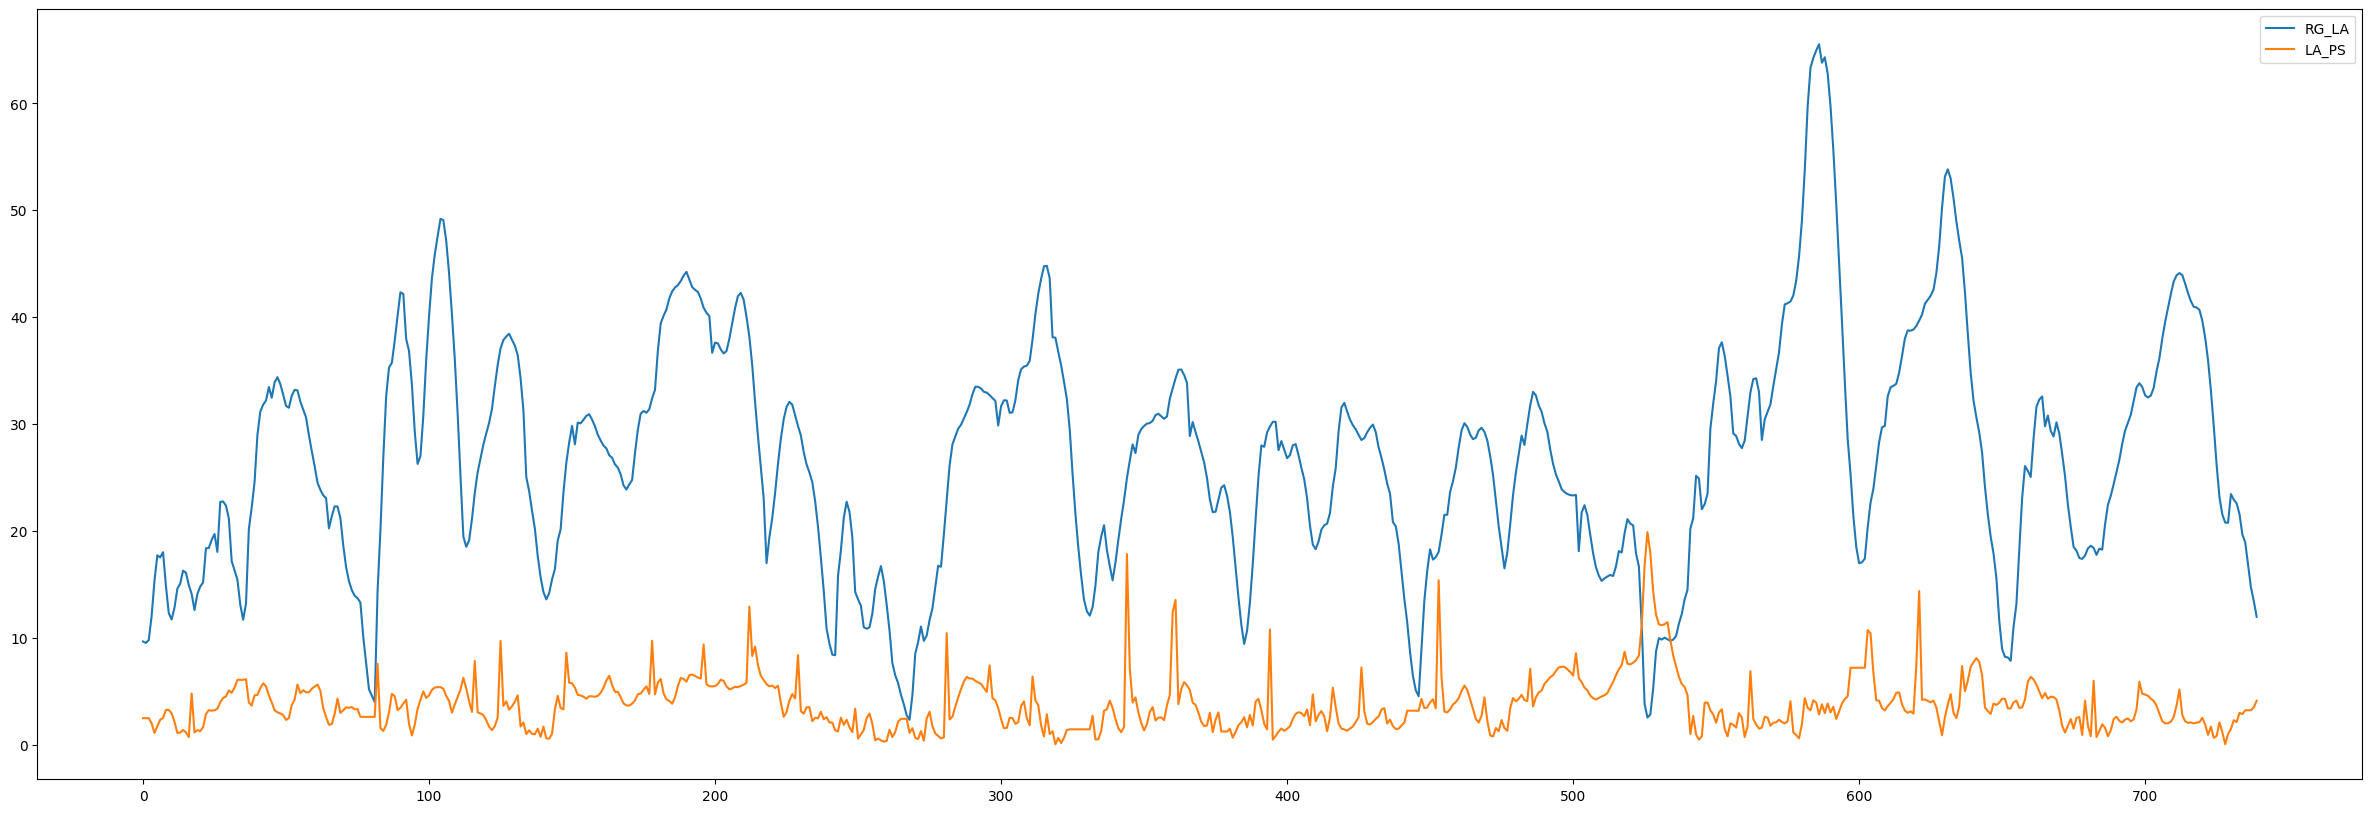

In [20]:
pd.DataFrame(platoon_alldist, columns = ['RG_LA', 'LA_PS']).plot(figsize=(30,10))

In [21]:
dist_v = pd.DataFrame(platoon_alldist, columns = ['RG_LA', 'LA_PS'])
pd.DataFrame(platoon_alldist, columns = ['RG_LA', 'LA_PS']).to_csv('distance_platoon.csv', index=False)

In [22]:
dist_coord = pd.concat([pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v1_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v1_lon'],pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v2_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v2_lon']], axis=1)

In [23]:
pd.concat([pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v1_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v1_lon'],pd.DataFrame(platoon_all_lat_dist, columns=['v1_lat', 'v2_lat'])['v2_lat'], pd.DataFrame(platoon_all_lon_dist, columns=['v1_lon', 'v2_lon'])['v2_lon']], axis=1).to_csv('platoon_distances_coord.csv', index=False)

In [24]:
infr = pd.read_csv('/home/selihadji/Documenti/papers/Platoon_II/infrast_data_update_.csv', sep=';')
infr.what.unique()

array(['Turn_left', '4-ways intersection', 'Traffic_light', 'Curve',
       'Road_immission', 'Turn_right'], dtype=object)

In [25]:
allveic = []
for k in range(0, len(dist_coord.columns)-1, 2):
    veic = []
    for i in range(len(dist_coord)):
        infra = []
        for j in range(len(infr)):
            inf = (infr.iloc[j].lon,infr.iloc[j].lat)
            distcoor = (dist_coord.iloc[i][str(dist_coord.columns[k+1])], dist_coord.iloc[i][str(dist_coord.columns[k])])
            infra.append(hs.haversine(inf,distcoor,unit=Unit.METERS))
        veic.append(infra)
    allveic.append(veic)

In [26]:
v1 = pd.DataFrame(allveic[0])
v2 = pd.DataFrame(allveic[1])

In [27]:
allfeat = []
for i in range(len(v1)): 
    allfeat.append(list(v1[v1<500].iloc[i].dropna()))
new_v1 = pd.DataFrame(allfeat).iloc[:,0:7].fillna(0)

In [28]:
allfeat = []
for i in range(len(v2)): 
    allfeat.append(list(v2[v2<500].iloc[i].dropna()))
new_v2 = pd.DataFrame(allfeat).iloc[:,0:7].fillna(0)

In [29]:
v1.columns = infr.what
v2.columns = infr.what

In [30]:
vlist = []
vlist.append(v1)
vlist.append(v2)

In [31]:
import statsmodels.api as sm

In [32]:
all_X = []
all_y = []

for k in range(len(vlist)):
    feats = []
    v = vlist[k]
    infrast = v.idxmin(axis=1)
    for i in range(len(v)):
        if (v.iloc[i][str(infrast[i])] < 80).any():
            feats.append([infrast[i]])
        else:
            feats.append([])
    new_v = pd.get_dummies(pd.DataFrame(feats), prefix='Feat')

    X = new_v.copy()
    y = dist_v[str(dist_v.columns[k])]
    X['old_dist'] = dist_v[str(dist_v.columns[k])].shift(10).fillna(0)
    all_X.append(X)
    all_y.append(y)

all_X_ = pd.concat(all_X).reset_index(drop=True).fillna(0)
all_y_ = pd.concat(all_y).reset_index(drop=True).fillna(0)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  LA_PS   R-squared (uncentered):                   0.632
Model:                            OLS   Adj. R-squared (uncentered):              0.628
Method:                 Least Squares   F-statistic:                              179.7
Date:                Tue, 01 Aug 2023   Prob (F-statistic):                   2.25e-154
Time:                        09:10:40   Log-Likelihood:                         -1798.1
No. Observations:                 740   AIC:                                      3610.
Df Residuals:                     733   BIC:                                      3642.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Feat_4-ways intersection     1.0812      0.508      2.128      0.034       0.084       2.079
Feat_Curve                   0.2487      0.519      0.479      0.632      -0.771       1.268
Feat_Road_immission          1.8514      0.523      3.537      0.000       0.824       2.879
Feat_Traffic_light           1.3498      0.184      7.333      0.000       0.988       1.711
Feat_Turn_left               1.3403      0.572      2.344      0.019       0.218       2.463
Feat_Turn_right              1.9215      0.416      4.623      0.000       1.106       2.737
old_dist                     0.5829      0.033     17.907      0.000       0.519       0.647
==============================================================================
Omnibus:                      222.851   Durbin-Watson:                   0.642
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1148.398
Skew:                           1.266   Prob(JB):                    4.25e-250
Kurtosis:                       8.553   Cond. No.                         26.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
results_summary = model.summary()
df = pd.DataFrame.from_records(results_summary.tables[1].data)
header = df.iloc[0]
df = df[1:] # take the data less the header row
df.columns = header
df.to_csv('platoon_II_14_09_11_45_.csv')

In [34]:
platoon_all_CO2_ = pd.DataFrame(platoon_all_CO2, columns = ['RG_LA', 'LA_PS'])
pd.DataFrame(platoon_all_CO2, columns = ['RW_LA', 'LA_PS']).to_csv('CO2_platoon.csv', index=False)

all_X = []
all_y = []

for k in range(len(vlist)):
    feats = []
    v = vlist[k]
    infrast = v.idxmin(axis=1)
    for i in range(len(v)):
        if (v.iloc[i][str(infrast[i])] <80).any():
            feats.append([infrast[i]])
        else:
            feats.append([])
    new_v = pd.get_dummies(pd.DataFrame(feats), prefix='Feat')

    X = new_v.copy()
    y = platoon_all_CO2_[str(platoon_all_CO2_.columns[k])]
    X['old_dist'] = dist_v[str(dist_v.columns[k])].shift(10).fillna(0)
    all_X.append(X)
    all_y.append(y)

all_X_ = pd.concat(all_X).reset_index(drop=True).fillna(0)
all_y_ = pd.concat(all_y).reset_index(drop=True).fillna(0)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  LA_PS   R-squared (uncentered):                   0.626
Model:                            OLS   Adj. R-squared (uncentered):              0.622
Method:                 Least Squares   F-statistic:                              175.2
Date:                Tue, 01 Aug 2023   Prob (F-statistic):                   7.28e-152
Time:                        09:10:41   Log-Likelihood:                          3172.0
No. Observations:                 740   AIC:                                     -6330.
Df Residuals:                     733   BIC:                                     -6298.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Feat_4-ways intersection     0.0042      0.001      6.836      0.000       0.003       0.005
Feat_Curve                   0.0024      0.001      3.790      0.000       0.001       0.004
Feat_Road_immission          0.0018      0.001      2.765      0.006       0.001       0.003
Feat_Traffic_light           0.0033      0.000     14.962      0.000       0.003       0.004
Feat_Turn_left               0.0023      0.001      3.376      0.001       0.001       0.004
Feat_Turn_right              0.0055      0.001     10.839      0.000       0.004       0.006
old_dist                     0.0003   3.94e-05      8.713      0.000       0.000       0.000
==============================================================================
Omnibus:                       23.536   Durbin-Watson:                   0.195
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.553
Skew:                           0.340   Prob(JB):                     3.83e-07
Kurtosis:                       3.705   Cond. No.                         26.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
results_summary = model.summary()
df = pd.DataFrame.from_records(results_summary.tables[1].data)
header = df.iloc[0]
df = df[1:] # take the data less the header row
df.columns = header
df.to_csv('platoon_II_14_09_11_45_CO2.csv')